This notebook contains the Twitter data experiment results where we applied Neural NCPD to the video tensor. Due to the non-convexity of the NCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper. 

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(1,"./src")

from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor2, Energy_Loss_Tensor, Recon_Loss, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm
from lsqnonneg_module import LsqNonneg
from trainNNCPD import train
#
import torch.nn as nn
from torch.autograd import Variable
from writer import Writer


import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

In [3]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Load in Twitter Data

In [4]:
words = np.load("./data/words_100.npy", allow_pickle=True)
X = np.load("./data/tweets_bag_100.npy", allow_pickle=True)


X = X.reshape((8, 10, -1))

X = torch.from_numpy(X)

## Run Neural NCPD

In [5]:
r=8
n1,n2,n3 = X.shape
net = NNCPD([n1,4,2],[n2,4,2],[n3,4,2])

loss_func = Energy_Loss_Tensor()

history_unsupervised = train(net, X, loss_func, r, epoch = 15000, lr1 = 0, lr2 = 0.1, random_init=True)


/home/jvendrow/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
X_1 = history_unsupervised.get('A_X1')[-1].detach().numpy()
X_2 = history_unsupervised.get('B_X1')[-1].detach().numpy()
X_3 = history_unsupervised.get('C_X1')[-1].detach().numpy()

A_A1 = history_unsupervised.get('A_A1')[-1].detach().numpy()
A_S1 = history_unsupervised.get('A_S1')[-1].detach().numpy()
B_A1 = history_unsupervised.get('B_A1')[-1].detach().numpy()
B_S1 = history_unsupervised.get('B_S1')[-1].detach().numpy()
C_A1 = history_unsupervised.get('C_A1')[-1].detach().numpy()
C_S1 = history_unsupervised.get('C_S1')[-1].detach().numpy()

A_A2 = history_unsupervised.get('A_A2')[-1].detach().numpy()
A_S2 = history_unsupervised.get('A_S2')[-1].detach().numpy()
B_A2 = history_unsupervised.get('B_A2')[-1].detach().numpy()
B_S2 = history_unsupervised.get('B_S2')[-1].detach().numpy()
C_A2 = history_unsupervised.get('C_A2')[-1].detach().numpy()
C_S2 = history_unsupervised.get('C_S2')[-1].detach().numpy()

## Display Top Keywords for all Layers

In [7]:
keywords = np.empty((7,8), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"
    
C = X_3

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top] 

print("RANK 8 KEYWORDS:")  
print("------------------")
col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))
    

C = C_A1

keywords = np.empty((7,4), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 4 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))


C = np.dot(C_A1, C_A2)

keywords = np.empty((7,2), dtype=object)

for i in range(keywords.shape[1]):
    keywords[0,i] = "Topic " + str(i+1)
    keywords[1,i] = "-------"

for i in range(C.shape[1]):
    col = C[:,i]
    top = col.argsort()
    top = top[-5:][::-1]

    keywords[2:,i] = words[top]

print("")
print("RANK 2 KEYWORDS:")  
print("------------------")

col_widths = [max([len(keywords[i][j]) for i in range(keywords.shape[0])])+2 for j in range(keywords.shape[1])]
for row in keywords:
    print("".join(row[i].ljust(col_widths[i]) for i in range(len(row))))


RANK 8 KEYWORDS:
------------------
Topic 1          Topic 2     Topic 3     Topic 4  Topic 5     Topic 6        Topic 7        Topic 8    
-------          -------     -------     -------  -------     -------        -------        -------    
martinomalley    marcorubio  johnkasich  crooked  tedcruz     senate         berniesanders  trump      
hillaryclinton   teammarco   kasich      hillary  cruz        florida        people         hillary    
realdonaldtrump  vote        ohio        thank    ted         zika           bernie         donald     
campaigning      flsen       john        great    internet    venezuela      must           president  
maryland         click       gov         clinton  choosecruz  nicolasmaduro  change         timkaine   

RANK 4 KEYWORDS:
------------------
Topic 1     Topic 2  Topic 3     Topic 4     
-------     -------  -------     -------     
tedcruz     trump    marcorubio  johnkasich  
cruz        hillary  teammarco   kasich      
ted         peo

## Display Rank 8 Factor Matrices
We note that the columns of the factor matrices could be permuted, topics could be in any order.

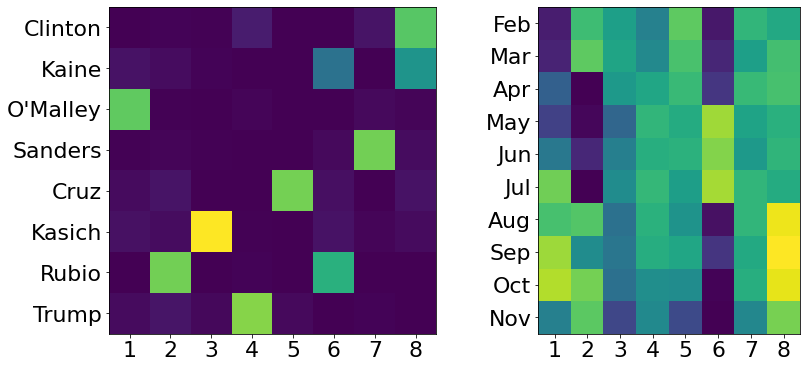

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,5))
color = "viridis"

plt.sca(axs[0])
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.xticks(range(8), range(1,9), fontsize=22)
plt.sca(axs[1])
plt.xticks(range(8), range(1,9), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(X_1, cmap=plt.get_cmap(color))
axs[1].imshow(X_2, cmap=plt.get_cmap(color))
plt.show()

In [9]:
def calculate_W(A, B, C, H_A, H_B, H_C):
    
    alphas = []
    n_1, r = A.shape
    n_2, r = B.shape
    n_3, r = C.shape
    weights = np.zeros((r, r, 2))
    
    
    for col in range(r):
        for it in range(r**2):
            i = int(it % r)
            j = int((it/r) % r)

            weights[col, i, 0] += np.sum(H_A[i] * H_B[j] * H_C[col]);
            weights[col, j, 1] += np.sum(H_A[i] * H_B[j] * H_C[col]);
         


    return weights

## Display Rank 4 Factor Matrices

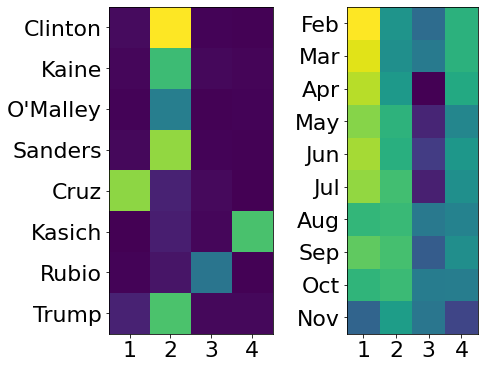

In [10]:
w = calculate_W(A_A1, B_A1, C_A1, A_S1, B_S1, C_S1)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(7,5))
color = "viridis"

A_A1_new = A_A1 @ w[:,:,0].T 
B_A1_new = B_A1 @ w[:,:,1].T

plt.sca(axs[0])
plt.xticks(range(4), range(1,5), fontsize=22)
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.sca(axs[1])
plt.xticks(range(4), range(1,5), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(A_A1_new, cmap=plt.get_cmap(color))
axs[1].imshow(B_A1_new, cmap=plt.get_cmap(color))
plt.show()

## Display Rank 2 Factor Matrices

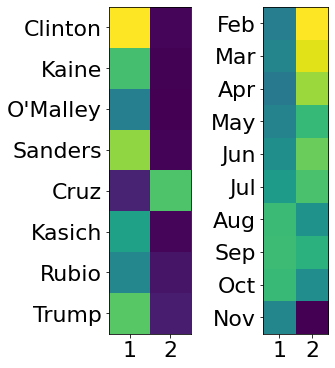

In [11]:
w = calculate_W(np.dot(A_A1,A_A2), np.dot(B_A1,B_A2), np.dot(C_A1,C_A2), A_S2, B_S2, C_S2)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(4.8,5))
color = "viridis"

A_new = np.dot(A_A1,A_A2) @ w[:,:,0].T
B_new = np.dot(B_A1,B_A2) @ w[:,:,1].T

plt.sca(axs[0])
plt.xticks(range(2), range(1,3), fontsize=22)
plt.yticks(range(8), ['Clinton', 'Kaine', 'O\'Malley', 'Sanders', 'Cruz', 'Kasich', 'Rubio', 'Trump'], fontsize=22)
plt.sca(axs[1])
plt.xticks(range(2), range(1,3), fontsize=22)
plt.yticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], fontsize=22)

axs[0].imshow(A_new, cmap=plt.get_cmap(color))
axs[1].imshow(B_new, cmap=plt.get_cmap(color))
plt.show()

## S Matrices
Note that these S matrices will not look as nice as the S matrices in the paper. This is because the order of topics in NCPD is arbitrary, so to get a "nice" S matrix one needs to reorder the topics

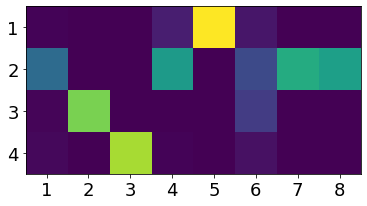

In [12]:
plt.xticks(range(0,8), range(1,9), fontsize=18)
plt.yticks(range(0,4), range(1,5), fontsize=18)

plt.imshow(C_S1)
plt.show()

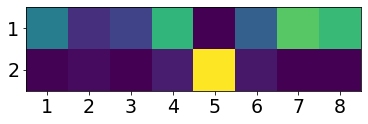

In [13]:

plt.xticks(range(0,8), range(1,9), fontsize=19)
plt.yticks(range(0,2), range(1,3), fontsize=19)

plt.imshow(C_S2)
plt.show()

In [14]:
X_np = X.numpy()

approx = outer_product_np(X_1, X_2, X_3)
print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
print()

approx = outer_product_np(A_A1 @ A_S1, B_A1 @ B_S1, C_A1 @ C_S1)
print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
print()

approx = outer_product_np(A_A1 @ A_A2 @ A_S2, B_A1 @ B_A2 @ B_S2, C_A1 @ C_A2 @ C_S2)
print("Reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2))
print("Relative reconstruction loss:", np.linalg.norm(np.ndarray.flatten(X_np-approx), 2)  / np.linalg.norm(np.ndarray.flatten(X_np), 2))
print()
The 

Reconstruction loss: 7.446640570183208
Relative reconstruction loss: 0.8325597259468726

Reconstruction loss: 7.895194077231405
Relative reconstruction loss: 0.8827095326121577

Reconstruction loss: 8.215136024200474
Relative reconstruction loss: 0.9184801297259811

